* Play a little with KG embedding learning from semmed kg. - For link prediction without predicates. i.e naive graph link prediction
* Note: `Subject : Predicate -> Object`
    
  * PyKeen , DL-KGE...
  * Could use StellarGraph (keras friendly but needs old python version)? https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/gcn-link-prediction.html ,
  * Ampligraph (Also tensorflow friendly) - https://docs.ampligraph.org/en/latest/examples.html
* https://pykeen.github.io/2020/08/07/benchmarking.html
    * rotatE, TuckER, TransE - do well
 
Relevant other paper did Trans-E on semmed : *"Evaluating Explanations from AI Algorithms for Clinical Decision-Making: A Social Science-based Approach"*


* pyKeen + curie biomed text represntations from entities to text (e.g. for transformer text rep) ; https://pykeen.readthedocs.io/en/stable/api/pykeen.nn.representation.BiomedicalCURIERepresentation.html#pykeen.nn.representation.BiomedicalCURIERepresentation

* * Load Pretrained models/representation, e.g. cui2vec : https://github.com/pykeen/pykeen/issues/637
  *  load init - https://pykeen.readthedocs.io/en/v1.8.1/reference/nn/init.html

In [1]:
MIN_EVIDENCE = 1#3#5 # filter counts/num of cases /pmids it appeared in - proxy to reduce noise
MIN_ENT_FREQ = 30#140#210 # keep only cases with this many occurrences

REMOVE_NEG_PREDICATES = False#True # remove predicates containnig "neg" as I don't know if we want them for now

RETRAIN_KG_MODEL = False

In [2]:
# !export PYTORCH_ENABLE_MPS_FALLBACK=1

In [3]:
import pandas as pd
import numpy as np
## scispacy, medspacy, medcat, quickumls, semrep...
# import spacy

In [4]:
# !pip install -U scikit-learn pykeen pandas

In [5]:
from pykeen.pipeline import pipeline
from pykeen.models import TransE
from pykeen.triples import TriplesFactory
# from pykeen.models.predict import get_tail_prediction_df
# https://pykeen.readthedocs.io/en/v1.10.2/api/pykeen.predict.predict_target.html#pykeen.predict.predict_target
from pykeen.predict import predict_target

# # https://pykeen.readthedocs.io/en/latest/tutorial/inductive_lp.html#label-based-transformer-representation
# ### "This is work in progress and not yet available." # pykeen.nn.representation import LabelBasedTransformerRepresentation

## https://pykeen.readthedocs.io/en/latest/api/pykeen.nn.init.LabelBasedInitializer.html
## Initialize entity representations as Transformer encodings of their labels. 
from pykeen.nn.init import LabelBasedInitializer
from pykeen.models import ERMLPE, ERModel
from pykeen.pipeline import pipeline
from pykeen.datasets import get_dataset
from pykeen.nn import TextRepresentation

import torch
import gc
torch.cuda.empty_cache()
gc.collect()

/opt/anaconda3/envs/nlp/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


0

In [6]:
from pykeen.datasets import get_dataset
from pykeen.models import ERModel, RotatE, TransR
from pykeen.nn.init import LabelBasedInitializer
from pykeen.pipeline import pipeline

# dataset = get_dataset(dataset="nations", dataset_kwargs=dict(create_inverse_triples=True))
# entity_initializer = LabelBasedInitializer.from_triples_factory(
#     triples_factory=dataset.training,
#     for_entities=True,
# )

# results = pipeline(
#     dataset=dataset,
#     # training=training,
#     # testing=testing,
#     # validation=validation,
#     model="distmult",
#     epochs=11,
#     evaluation_fallback = True,
#     stopper='early',
#     # device="mps",
# )


In [7]:
# ## load saved chkpoint from pykeen dir
# ## https://pykeen.readthedocs.io/en/stable/tutorial/checkpoints.html
# import torch
# from pykeen.constants import PYKEEN_CHECKPOINTS
# from pykeen.pipeline import pipeline
# from pykeen.triples import TriplesFactory
# # checkpoint = torch.load(PYKEEN_CHECKPOINTS.joinpath('my_checkpoint.pt'))

# # ## more styeps

# # from pykeen.models import TransE
# # my_model = TransE(triples_factory=train)
# # my_model.load_state_dict(checkpoint['model_state_dict'])

#### candidate_features names_list = names of features selected in previous stages
* candidate_feature_names_list - text names - free text. Made manually
* Other: CUIs list (CUIs linked to feature names + target cuis)

In [8]:
candidate_feature_names_list = pd.read_csv("../cand_feature_names.csv",header=None,quoting=1)[0]
candidate_feature_names_list

0                          'Age * Gender interaction'
1                                    'Abdominal pain'
2                                               'Sex'
3                            'Essential hypertension'
4                                               'age'
                            ...                      
145         'Other infectious and parasitic diseases'
146                          'Appendiceal conditions'
147     'Nystagmus and other irregular eye movements'
148                 'Fracture of clavicle or scapula'
149                                       'Fasciitis'
Name: 0, Length: 150, dtype: object

In [9]:
candidate_feature_cuis_list = pd.read_csv("../candidate_novel_cuis.csv",usecols=["cui"])#[0]
candidate_feature_cuis_list

,cui
0,C0027497
1,C4255480
2,C1171206
3,C0264694
4,C0151744
...,...
297,C0242401
298,C0376196
299,C0008350
300,C0242216


#### Load KG and filter rare entities/relations

In [10]:
%%time
df_kg = pd.read_parquet("predications.parquet",columns=['SUBJECT_CUI', 'SUBJECT_NAME',  'PREDICATE', 'OBJECT_CUI', 'OBJECT_NAME',"counts"])
print(df_kg.shape[0])

# CUI - name map for all cases in dataset
df_map = pd.concat([df_kg[['SUBJECT_CUI', 'SUBJECT_NAME']].rename(columns={'SUBJECT_NAME':"name",'SUBJECT_CUI':"CUI"}),
          df_kg[['OBJECT_CUI', 'OBJECT_NAME']].rename(columns={'OBJECT_NAME':"name",'OBJECT_CUI':"CUI"})]).drop_duplicates() 
print(df_map.shape[0],"df_map")

if REMOVE_NEG_PREDICATES:
    df_kg = df_kg.loc[~df_kg["PREDICATE"].str.contains("neg_",case=False)]
    print(df_kg.shape[0],"without neg predicates") # 26M
    
#########

df_kg = df_kg.loc[df_kg["counts"]>=MIN_EVIDENCE].copy()
print("After filtering min count",df_kg.shape[0])
df_kg = df_kg.loc[(df_kg.groupby("SUBJECT_CUI").transform("size")>MIN_ENT_FREQ) & (df_kg.groupby("OBJECT_CUI").transform("size")>MIN_ENT_FREQ)\
 & (df_kg.groupby("PREDICATE").transform("size")>MIN_ENT_FREQ)].copy()
print("After filtering entity count 1",df_kg.shape[0])
for c in df_kg.select_dtypes("category").columns:
# remove unobserved categories, in new filtered data
    df_kg[c] = df_kg[c].cat.remove_unused_categories()
# df_kg = df_kg.loc[(df_kg.groupby("SUBJECT_CUI").transform("size")>MIN_ENT_FREQ) & (df_kg.groupby("OBJECT_CUI").transform("size")>MIN_ENT_FREQ)\
# & (df_kg.groupby("PREDICATE").transform("size")>MIN_ENT_FREQ)].copy()
# print("After filtering entity count 2",df_kg.shape[0])

# for c in df_kg.select_dtypes("category").columns:
# # remove unobserved categories, in new filtered data
#     df_kg[c] = df_kg[c].cat.remove_unused_categories()
print(df_kg.shape[0]) # 4M
print(df_kg.nunique())
df_kg.drop(columns=["counts"],errors="ignore",inplace=True)

#########
## drop ||| gene objecgts (that require exploding 
#Old: dropped them instead of getting just the first : # df_kg = df_kg.loc[(~df_kg["SUBJECT_NAME"].str.contains(r"|",case=False,regex=False))&(~df_kg["OBJECT_NAME"].str.contains("|",case=False,regex=False))]
splitter_mask = (df_kg["SUBJECT_CUI"].str.contains(r"|",case=False,regex=False)) | (df_kg["OBJECT_CUI"].str.contains(r"|",case=False,regex=False))
for col in df_kg.select_dtypes(include=['category']).columns:
  df_kg[col] = df_kg[col].astype('str')
    
df_kg.loc[splitter_mask,"SUBJECT_NAME"] = df_kg.loc[splitter_mask]["SUBJECT_NAME"].str.split(r"|",regex=False,expand=True)[0]
df_kg.loc[splitter_mask,"OBJECT_NAME"] = df_kg.loc[splitter_mask]["OBJECT_NAME"].str.split(r"|",regex=False,expand=True)[0]

df_kg.loc[splitter_mask,"SUBJECT_CUI"] = df_kg.loc[splitter_mask]["SUBJECT_CUI"].str.split(r"|",regex=False,expand=True)[0]
df_kg.loc[splitter_mask,"OBJECT_CUI"] = df_kg.loc[splitter_mask]["OBJECT_CUI"].str.split(r"|",regex=False,expand=True)[0]

for col in df_kg.select_dtypes(include=['O']).columns:
  df_kg[col] = df_kg[col].astype('category')
df_kg.loc[splitter_mask]
print(df_kg.shape[0],"Without |'s") # 26M

df_kg.reset_index(drop=True)

df_kg

27350365
416050 df_map
23216325 Without |'s
After filtering min count 23216325


<timed exec>:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


After filtering entity count 1 21292838
21292838
SUBJECT_CUI     81542
SUBJECT_NAME    92959
PREDICATE          63
OBJECT_CUI      71507
OBJECT_NAME     82192
counts           3945
dtype: int64
CPU times: user 15.7 s, sys: 2.3 s, total: 18 s
Wall time: 14.2 s


,SUBJECT_CUI,SUBJECT_NAME,PREDICATE,OBJECT_CUI,OBJECT_NAME
2101,C0087111,Therapeutic procedure,TREATS,C0030705,Patients
747,C0040395,tomography,USES,C1441526,COMPUTED
3274,C0012634,Disease,PROCESS_OF,C0030705,Patients
5161,C0543467,Operative Surgical Procedures,TREATS,C0030705,Patients
33,C1457887,Symptoms,PROCESS_OF,C0030705,Patients
...,...,...,...,...,...
101678940,1,A1BG,AFFECTS,C0036421,Systemic Scleroderma
69169934,1,A1BG,AFFECTS,C0028754,Obesity
29880800,1,A1BG,AFFECTS,C0020291,Hydrolysis
66983871,1,A1BG,AFFECTS,C0005935,Bone Conduction


In [11]:
df_kg.PREDICATE.value_counts()

PREDICATE
LOCATION_OF           2659312
AFFECTS               2088043
COEXISTS_WITH         1756359
TREATS                1737930
INTERACTS_WITH        1425989
                       ...   
NEG_COMPLICATES          1371
NEG_CONVERTS_TO           943
NEG_lower_than            553
MEASUREMENT_OF            485
NEG_MEASUREMENT_OF         21
Name: count, Length: 63, dtype: int64

In [12]:
# ## "novelty" look?
# ## partial mini list. Not exhaustive
# subsetPredicates = {"AFFECTS","TREATS","PREVENTS","INHIBITS","DISRUPTS","INTERACTS_WITH","PREDISPOSES","PREVENTS",
#                     "CAUSES","STIMULATES","AUGMENTS","PREDISPOSES","PRECEDES",
#                     "NEG_TREATS","NEG_AFFECTS","NEG_PROCESS_OF","NEG_ISA","NEG_ASSOCIATED_WITH","NEG_CAUSES"} # made into set instead of list


# if REMOVE_NEG_PREDICATES:
#     subsetPredicates = [x for x in subsetPredicates if "NEG" not in x]

# # df_kg.loc[df_kg["SUBJECT_NOVELTY"] | df_kg["OBJECT_NOVELTY"]].head(10)
# df_kg.loc[(df_kg["OBJECT_NOVELTY"]) & (df_kg["PREDICATE"].isin(subsetPredicates))].head(4)

# # subsetPredicates = dict(subsetPredicates)

### Use only 1 predicate - link exists or not
* Technically, directional predicate in terms of how data was

In [13]:
df_kg["PREDICATE"] = "link"
print(df_kg.shape[0])
df_kg.drop_duplicates(inplace=True)
print(df_kg.shape[0])

21292838
16522876


In [14]:
df_kg

,SUBJECT_CUI,SUBJECT_NAME,PREDICATE,OBJECT_CUI,OBJECT_NAME
2101,C0087111,Therapeutic procedure,link,C0030705,Patients
747,C0040395,tomography,link,C1441526,COMPUTED
3274,C0012634,Disease,link,C0030705,Patients
5161,C0543467,Operative Surgical Procedures,link,C0030705,Patients
33,C1457887,Symptoms,link,C0030705,Patients
...,...,...,...,...,...
17949225,1,A1BG,link,C0597304,Proteolysis
114264339,1,A1BG,link,C0549099,Perforation (observation)
69169934,1,A1BG,link,C0028754,Obesity
29880800,1,A1BG,link,C0020291,Hydrolysis


* Training - assumption of LCWA
* https://pykeen.readthedocs.io/en/stable/reference/training.html#local-closed-world-assumption
* hetionet example inc loading ,eval: https://github.com/tomasonjo/blogs/blob/master/pykeen/Hetionet%20-%20RotatE.ipynb

* mps -> memory issues/crashes?

* Another example pykeen : https://pykeen.readthedocs.io/en/stable/tutorial/first_steps.html
* RotatE seems good from lit, on hetionet
* pubmedKG for text/sentencetransformer embedding?
* GCN https://pykeen.readthedocs.io/en/stable/reference/nn/pyg_message_passing.html

In [15]:
%%time
from pykeen.nn import TextRepresentation
## https://pykeen.readthedocs.io/en/latest/tutorial/representations.html#text-based

### load new data example: https://towardsdatascience.com/knowledge-graph-completion-with-pykeen-and-neo4j-6bca734edf43
# .astype("category")
tf = TriplesFactory.from_labeled_triples(
  df_kg.rename(columns={"SUBJECT_NAME":"source",
                        "PREDICATE":"type",
                        "OBJECT_NAME":"target"})[["source", "type", "target"]].values ,
)

CPU times: user 21.3 s, sys: 1.34 s, total: 22.7 s
Wall time: 21.2 s


In [16]:
training, testing, validation = tf.split([.96, .02, .02])
# training, testing, validation = tf.split([.8, .1, .1])

using automatically assigned random_state=1791497232


* Another text-kg example code inc triples:
    * https://gist.github.com/airysen/2b4f8b5dff8cc72b8951d4457228a7bd
Example of using LM embeddings in pykeen
```

from pykeen.training import SLCWATrainingLoop
from pykeen.datasets import get_dataset
from pykeen.nn.representation import TextRepresentation
from pykeen.models import ERModel

from pykeen.pipeline import pipeline

from torch.optim import Adam


dataset = get_dataset(dataset="nations")
entity_representations = TextRepresentation.from_triples_factory(
    triples_factory=dataset.training,
    encoder="transformer",
    encoder_kwargs=dict(pretrained_model_name_or_path="bert-base-multilingual-uncased", max_length=512)
)


model = ERModel(
    triples_factory=dataset.training,
    interaction="ermlpe",
    entity_representations=entity_representations,
    relation_representations_kwargs=dict(shape=entity_representations.shape),
    interaction_kwargs=dict(embedding_dim=entity_representations.shape[0], input_dropout=0.1, hidden_dim=256, hidden_dropout=0.2),
    entity_representations_kwargs=dict(max_length=512),
    random_seed=42,
    # relation_representations_kwargs=dict(embedding_dim=3, dropout=0.1),
)


```

In [17]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [21]:
%%time
try: # load already trained res
    results = torch.load('./saved/trained_model.pkl') # try this ? 
except:
    try:
        results = torch.load('./saved/trained_model.pkl',map_location=torch.device('cpu')) # try this ? 
    except:()
    

CPU times: user 3.41 ms, sys: 15.6 ms, total: 19 ms
Wall time: 55.2 ms


Training epochs on cuda:0:   0%|          | 0/60 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/330k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 2075.34s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.03873316212811319. Saved model weights to /home/ddofer/.data/pykeen/checkpoints/best-model-weights-840cf381-788a-4243-a951-4ace4f5e72eb.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/330k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 1099.32s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 20: 0.04530629179184029. Saved model weights to /home/ddofer/.data/pykeen/checkpoints/best-model-weights-840cf381-788a-4243-a951-4ace4f5e72eb.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 20.


Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/330k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 1099.26s seconds


Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/61914 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/330k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 1099.07s seconds
INFO:pykeen.stoppers.early_stopping:Stopping early at epoch 40. The best result 0.04530629179184029 occurred at epoch 20.
INFO:pykeen.stoppers.early_stopping:Re-loading weights from best epoch from /home/ddofer/.data/pykeen/checkpoints/best-model-weights-840cf381-788a-4243-a951-4ace4f5e72eb.pt


Evaluating on cuda:0:   0%|          | 0.00/330k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 1939.54s seconds
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=105270, num_relations=1, create_inverse_triples=False, num_triples=15849939) to file:///mnt/c/Users/ddofe/OneDrive%20-%20Medtronic%20PLC/Documents/research/InterestingFeats/SemMed/saved/training_triples
INFO:pykeen.pipeline.api:Saved to directory: /mnt/c/Users/ddofe/OneDrive - Medtronic PLC/Documents/research/InterestingFeats/SemMed/saved


CPU times: user 9h 10min 5s, sys: 16min 30s, total: 9h 26min 35s
Wall time: 9h 28min 52s


PipelineResult(random_seed=42, model=ComplEx(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (interaction): ComplExInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (regularizer): LpRegularizer()
      (_embeddings): Embedding(105270, 400)
    )
  )
  (relation_representations): ModuleList(
    (0): Embedding(
      (regularizer): LpRegularizer()
      (_embeddings): Embedding(1, 400)
    )
  )
  (weight_regularizers): ModuleList()
), training=TriplesFactory(num_entities=105270, num_relations=1, create_inverse_triples=False, num_triples=15849939), training_loop=<pykeen.training.slcwa.SLCWATrainingLoop object at 0x7f325b6dd270>, losses=[1.3756489105334666, 0.53852825813684, 0.3774341188625575, 0.3078338511132449, 0.2598190537419837, 0.22490091910276794, 0.20074894008072872, 0.1843567073634476, 0.1731472771170624, 0.16476586288015752, 0.15880649133344146, 0.1536467188724548, 0.14927812772025176, 0.14626408621136203, 0.1435445282769162, 0.

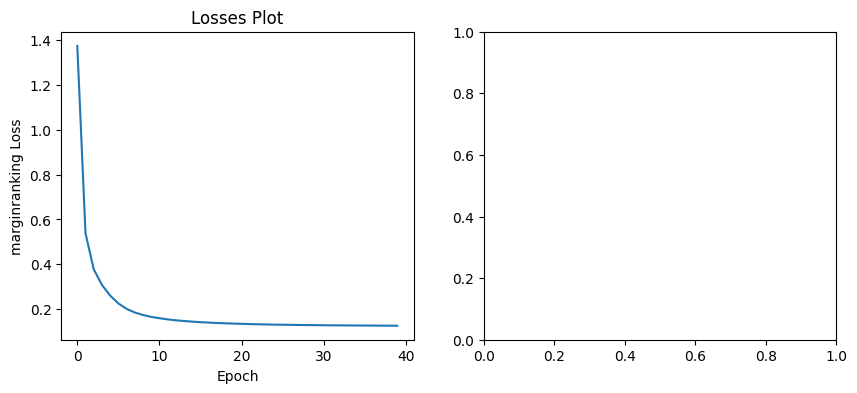

In [19]:
%%time
if RETRAIN_KG_MODEL:
        
    results = pipeline(
        training=training,
        testing=testing,
        validation=validation,
        # model= "TransD" #"TransH"#"TuckER"#"TransD"#'Complex',#"TuckER",
        # model='DistMult' ## this seems to work, without crashing, on cpu
         # model="ermlpe"
        model="ComplEx"
        ,epochs= 60#3#80
        ,dimensions= 500#128
        ,random_seed=42,
        # device='mps', ## apple silicon - crashes OOM ; but works with cpu? depends on size, embed size
        # device="cpu", # "cuda" # runs stably on cuda
        evaluation_fallback = True,
        stopper='early', ## may crash? 
        # stopper = None,
    
        # evaluation_relation_whitelist=subsetPredicates ## evaluate only on subset of relations
    
        # # training_loop_kwargs=dict(automatic_memory_optimization=False), # ,batch_size=1024
        # evaluator_kwargs=dict(automatic_memory_optimization=False,batch_size=64), # batch_size
    )
    
    try:
        results.plot()
    except:()
    
    results.save_to_directory('./saved/')


# model = torch.load('./saved/trained_model.pkl')

results

In [20]:
# results.save_to_directory('./saved/')

#### Transformer embeedder after this - I couldn't get it working great? 

In [21]:
# ## try new 
# entity_initializer = LabelBasedInitializer.from_triples_factory(
#     triples_factory=training,
#     for_entities=True,
#     encoder="transformer",
#      # model_kwargs=dict(device="mps") # doesn't work
# )

# ### https://pykeen.readthedocs.io/en/latest/tutorial/representations.html#text-based

In [22]:
# # entity_representations = TextRepresentation.from_dataset(
# #     dataset=tf,
# #     encoder="transformer",
# # )

# entity_representations = TextRepresentation.from_triples_factory(
#     triples_factory=tf,
#     encoder="transformer",
# )

In [23]:
# dataset = get_dataset(dataset="nations")
# entity_representations = TextRepresentation.from_dataset(
#     dataset=dataset,
#     encoder="transformer",
# )
# result = pipeline(
#     dataset=dataset,
#     model=ERModel,
#     model_kwargs=dict(
#         # interaction= "TransE",, # not using ermlpe -> error
#         interaction="ermlpe", # not using ermlpe -> error
        
#         interaction_kwargs=dict(
#             embedding_dim=entity_representations.shape[0],
#         ),
#         entity_representations=entity_representations,
#         relation_representations_kwargs=dict(
#             shape=entity_representations.shape,
#         ),
#     ),
#     training_kwargs=dict(
#         num_epochs=2,
#     ),
# )
# model = result.model
# result.plot()

In [24]:
# %%time
# from pykeen.models import ERModel
# ## memory crash on apple silicon in eval
# ## may have cpu memory leak - when running with more epochs. 

# rot_results = pipeline(
#     training=training,
#     testing=testing,
#     validation=validation,
#     model=ERModel, #"TransE",#"TransH", #"TransR",#"TransE",#"TransH", #'RotatE', # aten::complex.out - not supported on mps
#      # model= "QuatE",
#     # model="convKB", ## To be consistent with the paper, should initialize entity and relation embeddings from TransE.
#     # model="RotatE",
#     # model="TuckER",
#     # epochs=2#35,
#     epochs=2,
#     # dimensions= 512,
#     random_seed=42,
#     # device='mps', ## apple silicon - crashes OOM ; but works with cpu? depends on size, embed size
#     # device="cpu", # "cuda" # runs stably on cuda
#     evaluation_fallback = True,
#     stopper='early', ## may crash? 
#     # evaluation_relation_whitelist=subsetPredicates, ## evaluate only on subset of relations
    
#     # # ## try adding for Transformer embed
#     # model_kwargs=dict(entity_representations_kwargs=dict(
#     #         # triples_factory=dataset.training,
#     #         base_kwargs=dict(
#     #             # shape=embedding_dim,
#     #             initializer=entity_initializer,
#     #         ))),

#     model_kwargs=dict(
#         interaction="ermlpe",
#         # interaction="transe",
#         interaction_kwargs=dict(
#             embedding_dim=entity_representations.shape[0],
#         ),
#         entity_representations=entity_representations,
#         relation_representations_kwargs=dict(
#             shape=entity_representations.shape,
#         ),
#         ),
# )

# try:
#     rot_results.plot()
# except:()

# ## 79/80 [39:19<00:11, 11.65s/epoch, loss=0.0471, prev_loss=0.0475]

In [25]:
# from pykeen.models import *
# ## not working
# model = ERMLPE(
#     triples_factory=tf, #I added - try
#     embedding_dim=768,  # for BERT base
#     entity_initializer=LabelBasedInitializer.from_triples_factory(
#         triples_factory=tf #tf #training, #dataset.training,
#         ,encoder="transformer",
#     ),
# )

In [26]:
# conv_results = pipeline(
#     training=training,
#     testing=testing,
#     validation=validation,
#     model="convKB",
#     epochs=40,
#     dimensions=300, #512,
#     random_seed=42,
#     evaluation_fallback = True,
#     stopper='early', ## may crash? 
#     evaluation_relation_whitelist=subsetPredicates ## evaluate only on subset of relations
# )

# try:
#     conv_results.plot()
# except:()
#     ## errorrrrr

In [27]:
# gcn_results = pipeline(
#     training=training,
#     testing=testing,
#     validation=validation,
#     model= "AutoSF" #"CompGCN",
#     ,epochs=70,
#     dimensions= 300,
#     random_seed=42,
#     evaluation_fallback = True,
#     stopper='early', ## may crash? 
#     evaluation_relation_whitelist=subsetPredicates ## evaluate only on subset of relations
# )
# try:
#     gcn_results.plot()
# except:() # loss=0.0924, prev_loss=0.0923] - autosf , 40 epochs. didn't saturate

In [28]:
# results =gcn_results

` 'training_loop_kwargs': {}, 'evaluator': 'RankBasedEvaluator', 'evaluator_kwargs': {},  'batch_size': 256, `

In [29]:
results.model

ComplEx(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (interaction): ComplExInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (regularizer): LpRegularizer()
      (_embeddings): Embedding(105270, 400)
    )
  )
  (relation_representations): ModuleList(
    (0): Embedding(
      (regularizer): LpRegularizer()
      (_embeddings): Embedding(1, 400)
    )
  )
  (weight_regularizers): ModuleList()
)

### Scoring/try - link prediction
* https://pykeen.readthedocs.io/en/v1.10.2/api/pykeen.predict.predict_target.html#pykeen.predict.predict_target

In [30]:
# query = "Multiple Sclerosis"#"Termination of pregnancy" #"Pregnancy" #"Diet"
query = "Cholelithiasis"
df_known = df_kg.loc[(df_kg['SUBJECT_NAME'].str.contains(query,case=False))|(df_kg['OBJECT_NAME'].str.contains(query,case=False))].drop_duplicates()
df_known

,SUBJECT_CUI,SUBJECT_NAME,PREDICATE,OBJECT_CUI,OBJECT_NAME
72162,C0008350,Cholelithiasis,link,C0030705,Patients
360204,C0162522,"Cholecystectomy, Laparoscopic",link,C0008350,Cholelithiasis
166953,C0008350,Cholelithiasis,link,C0012634,Disease
1330414,C0008320,Cholecystectomy,link,C0008350,Cholelithiasis
103860091,C0008320,Cholecystectomy procedure,link,C0008350,Cholelithiasis
...,...,...,...,...,...
394246,3162,HMOX1,link,C0008350,Cholelithiasis
80404575,29881,NPC1L1,link,C0008350,Cholelithiasis
120956921,28982,FLVCR1,link,C0008350,Cholelithiasis
88660470,2167,FABP4,link,C0008350,Cholelithiasis


In [31]:
# df = get_tail_prediction_df(
#     model=result.model,
#     head_label="belgium",
#     relation_label="locatedin",
#     triples_factory=result.training,
#     add_novelties=False,
# )

df_preds_res = predict_target(model=results.model,
    head=query,
      # tail=query,
    # relation="AFFECTS",
      relation="link",
    # triples_factory=results.testing,
               triples_factory=tf
    ).df

df_preds_res = df_preds_res.round(3)
df_preds_res

,tail_id,score,tail_label
16106,16106,14.911,Cholelithiasis
41349,41349,7.906,"Jaundice, Obstructive"
22072,22072,7.721,Diabetes Mellitus
38184,38184,7.694,Icterus
32028,32028,7.537,Gall Bladder Diseases
...,...,...,...
70917,70917,-4.733,Simulations
101939,101939,-4.757,simulation
63574,63574,-4.798,Qualitative Research
82515,82515,-5.231,Work


In [32]:
# df_diet_known = df_kg.loc[(df_kg['SUBJECT_NAME']=="Diet")&(df_kg['PREDICATE']=="AFFECTS")].drop_duplicates()
# df_diet_known

In [33]:
## known preds
print("Cases in known",df_preds_res.loc[df_preds_res["tail_label"].isin(df_known["OBJECT_NAME"])].shape[0])
min_score_real = df_preds_res.loc[df_preds_res["tail_label"].isin(df_known["OBJECT_NAME"])]["score"].min()
print("lowest scored of real known cases",min_score_real)

Cases in known 658
lowest scored of real known cases 0.032


In [34]:
## novel preds
df_novel_cand = df_preds_res.loc[~df_preds_res["tail_label"].isin(df_known["OBJECT_NAME"])]
print(df_novel_cand.shape[0],"total unfil novel candidates")
df_novel_cand = df_novel_cand.loc[df_novel_cand["score"]>=min_score_real]
print(df_novel_cand.shape[0],"Filtered score novel candidates")
# df_novel_cand

## get CUIs and free text (for comparing/m,atching)
df_novel_cand = df_novel_cand.merge(df_map,left_on="tail_label",right_on="name",how="inner").drop(columns="name").drop_duplicates()
df_novel_cand

104612 total unfil novel candidates
53942 Filtered score novel candidates


,tail_id,score,tail_label,CUI
0,35310,7.169,Helicobacter Infections,C0079487
1,17173,6.473,Clinical finding,C0586173
2,17951,6.290,Comorbidity,C0009488
3,44445,6.279,Liver Abscess,C0023885
4,14759,6.254,Celiac Disease,C0007570
...,...,...,...,...
54172,96037,0.032,methyl 5-aminolevulinate,C1134467
54173,27725,0.032,Esthesiometer,C0180759
54174,45373,0.032,M2-Type Pyruvate Kinase,C0079782
54175,12814,0.032,CNTF,1270


### Novel candidates that are also likely to be missing links (from our preds): 

In [35]:
df_novel_cand.loc[df_novel_cand["CUI"].isin(candidate_feature_cuis_list["cui"])]

,tail_id,score,tail_label,CUI
14,41023,5.921,Iron deficiency anemia,C0162316
71,81764,5.392,Vitamin D Deficiency,C0042870
91,80364,5.273,Uterine Fibroids,C0042133
96,35654,5.245,Hemorrhoids,C0019112
131,80834,5.092,Varicosity,C0042345
...,...,...,...,...
46784,54561,0.163,Opiates,C0376196
50946,19432,0.083,Creation of ileostomy,C0020883
51586,29625,0.073,Female stress incontinence,C0038437
53013,7867,0.049,Atopic rhinitis,C0002103


* Alt: candidates for what prevents a disease (mayu also want to look at "neagtuively affected by")

In [37]:
# object_cand_query = "Multiple Sclerosis"
object_cand_query = "Cholelithiasis"

In [38]:

# NEG_PREDICATES = ["CAUSES",'INHIBITS','PREVENTS', 'TREATS'] # ,'DISRUPTS',  - most common res, includes cytokines
NEG_PREDICATES = ["link"]
df_preds_res = pd.DataFrame()

for p in NEG_PREDICATES:
    print(p)
    df_temp = predict_target(model=results.model,
        # head=query,
        relation= p,#"PREVENTS", ##subsetPredicates
         tail=object_cand_query,
         triples_factory=tf).df
    df_temp["predicate"]= p
    df_preds_res = pd.concat([df_preds_res,df_temp])
    
df_preds_res = df_preds_res.drop_duplicates(subset=["head_label","predicate"]).round(2)
# df_known = df_kg.loc[(df_kg['OBJECT_NAME']==object_cand_query)&(df_kg['PREDICATE']=="PREVENTS")]
df_known = df_kg.loc[(df_kg['OBJECT_NAME']==object_cand_query)&(df_kg['PREDICATE'].isin(NEG_PREDICATES))]
df_preds_res = df_preds_res.loc[~df_preds_res["head_label"].isin(df_known["OBJECT_NAME"])].sort_values("score",ascending=False)#.head(25)
### filterr by min real score i.e score of known cases
min_score_real = df_preds_res.loc[df_preds_res["head_label"].isin(df_known["SUBJECT_NAME"])]["score"].min()
df_preds_res = df_preds_res.loc[df_preds_res["score"]>=min_score_real]

# df_preds_res#.head(25)

link


,head_id,score,head_label,predicate
38184,38184,8.92,Icterus,link
22072,22072,7.76,Diabetes Mellitus,link
32031,32031,7.67,Gallbladder,link
9872,9872,7.62,Bile Acids,link
16076,16076,7.49,Cholecystectomy,link
...,...,...,...,...
69411,69411,0.04,Scrophulariaceae,link
58860,58860,0.04,Phagolysosomes,link
55776,55776,0.04,PC 16,link
37518,37518,0.04,Hypochromatism,link


In [39]:
## get CUIs and free text (for comparing/m,atching)
df_preds_res = df_preds_res.merge(df_map,left_on="head_label",right_on="name",how="inner").drop(columns="name").drop_duplicates()
print(df_preds_res.shape[0])

df_preds_res.loc[df_preds_res["CUI"].isin(candidate_feature_cuis_list["cui"])]

80833


,head_id,score,head_label,predicate,CUI
138,9924,5.78,Biliary calculi,link,C0242216
182,16091,5.63,Cholecystolithiasis,link,C0947622
287,32262,5.36,Gastric ulcer,link,C0038358
318,41023,5.29,Iron deficiency anemia,link,C0162316
321,2885,5.28,Abnormality,link,C1704258
...,...,...,...,...,...
79881,35173,0.05,"Hearing Loss, Partial",link,C0018772
79884,69897,0.05,Senile cataract,link,C0036646
79908,77501,0.05,Tobacco Use Disorder,link,C0040336
80181,32837,0.05,Geographic atrophy,link,C1536085


Example feature: (low score but passes)
`1.72	Shared Paranoid Disorder	C0036939`
* This actually makes sense! e.g. see: 
* "The Surprising Link Between the Liver and Mental Health""ve, liver disease can be a direct cause of mental health symptoms because a compromised liver cannot prevent toxin"...
* "When liver function is disrupted, toxins accumulate in the blood and often travel to the brain, increasing the likelihood of affecting brain function. Liver disease patients are three times more likely to simultaneously be living with depressive disorders".


Another: `1.72	 Dyspareunia		C1384606`
* "A Case of Gallstones Causing Pelvic Pain"
* "Missed Gallstones in the Bile Duct and Abdominal Cavity"v)
https://www.ncbi.nlm.nih.gov › articles › PMC2664139
by O Irkorucu · 20,5 The other rare complications of LC are as follows: ovarian stone implantation, tubalithiasis, dyspareunia, chronic pelvic pain, small bowel ...

In [40]:
df_preds_res.score.describe()

count    80833.000000
mean         1.231917
std          0.994020
min          0.040000
25%          0.510000
50%          0.990000
75%          1.660000
max          8.920000
Name: score, dtype: float64

In [41]:
# df_preds_res.loc[df_preds_res["predicate"]=="PREVENTS"][["head_label","predicate"]].head(24)["head_label"].values.to_clipboard()
df_preds_res.loc[df_preds_res["predicate"]=="PREVENTS"][["head_label","predicate"]].head(24)

,head_label,predicate


In [42]:
# df_preds_res.loc[df_preds_res["predicate"]=="TREATS"][["head_label","predicate"]].head(30).to_clipboard()

df_preds_res.loc[df_preds_res["predicate"]=="INHIBITS"][["head_label","predicate"]].head(30)#.to_clipboard()

,head_label,predicate


In [43]:
df_preds_res[["head_label","predicate"]].head(33)

,head_label,predicate
0,Icterus,link
1,Diabetes Mellitus,link
2,Gallbladder,link
3,Bile Acids,link
4,Cholecystectomy,link
5,Hyperlipidemia,link
6,Cholestasis,link
7,Cholecystitis,link
8,Gall Bladder Diseases,link
9,Entire biliary tract,link


In [44]:
df_known

,SUBJECT_CUI,SUBJECT_NAME,PREDICATE,OBJECT_CUI,OBJECT_NAME
360204,C0162522,"Cholecystectomy, Laparoscopic",link,C0008350,Cholelithiasis
1330414,C0008320,Cholecystectomy,link,C0008350,Cholelithiasis
103860091,C0008320,Cholecystectomy procedure,link,C0008350,Cholelithiasis
1299705,C0543467,Operative Surgical Procedures,link,C0008350,Cholelithiasis
2030483,C0041618,Ultrasonography,link,C0008350,Cholelithiasis
...,...,...,...,...,...
394246,3162,HMOX1,link,C0008350,Cholelithiasis
80404575,29881,NPC1L1,link,C0008350,Cholelithiasis
120956921,28982,FLVCR1,link,C0008350,Cholelithiasis
88660470,2167,FABP4,link,C0008350,Cholelithiasis
